In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit

In [2]:
# Reading and cleaning dataset
gdp_data = pd.read_csv('data/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_6298243.csv', skiprows=4)
gdp_data = gdp_data.dropna(axis=1, how='all')
year_columns = gdp_data.columns[4:]
gdp_data[year_columns] = gdp_data[year_columns].fillna(0)
gdp_data = gdp_data.drop_duplicates()
gdp_data[year_columns] = gdp_data[year_columns].astype(float)
for year in year_columns:
    mean_value = gdp_data[year].mean()
    std_dev = gdp_data[year].std()
    outlier_threshold = mean_value + 3 * std_dev
    gdp_data[year] = gdp_data[year].clip(upper=outlier_threshold)


/home/indexworld/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


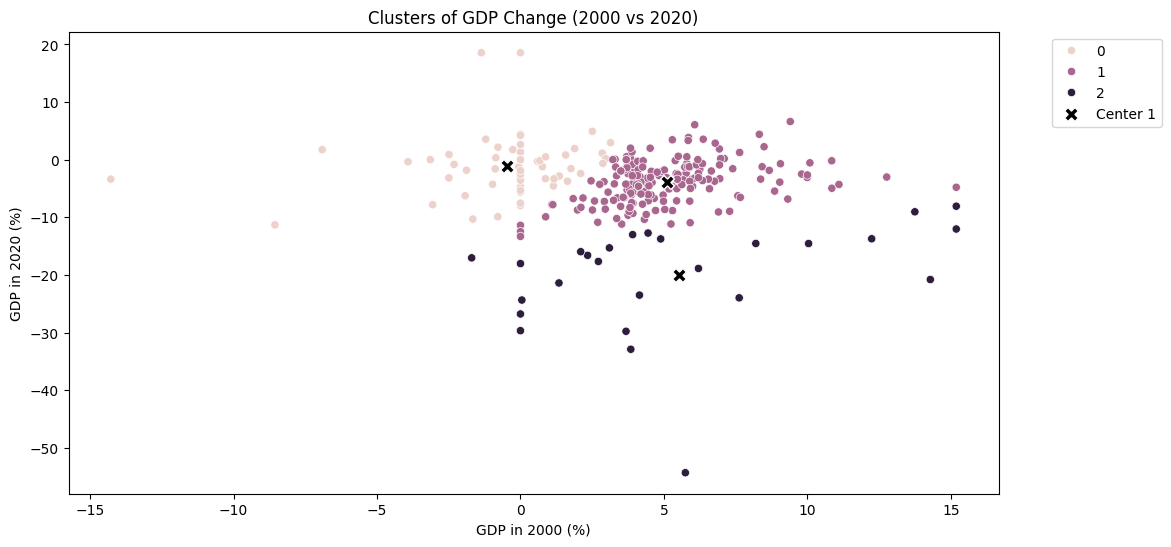

In [3]:
cluster_df = gdp_data[['Country Name', '2000', '2020']].dropna()
cluster_df['Change_2000_2020'] = cluster_df['2020'] - cluster_df['2000']

scaler = StandardScaler()
normalized_data = scaler.fit_transform(cluster_df[['2000', '2020', 'Change_2000_2020']])

# Applying K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_df['Cluster'] = kmeans.fit_predict(normalized_data)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=cluster_df, x='2000', y='2020', hue='Cluster', legend='full')
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], color='black', marker='X', s=100, edgecolor='w', label=f'Center {i+1}' if i == 0 else None)

plt.title('Clusters of GDP Change (2000 vs 2020)')
plt.xlabel('GDP in 2000 (%)')
plt.ylabel('GDP in 2020 (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

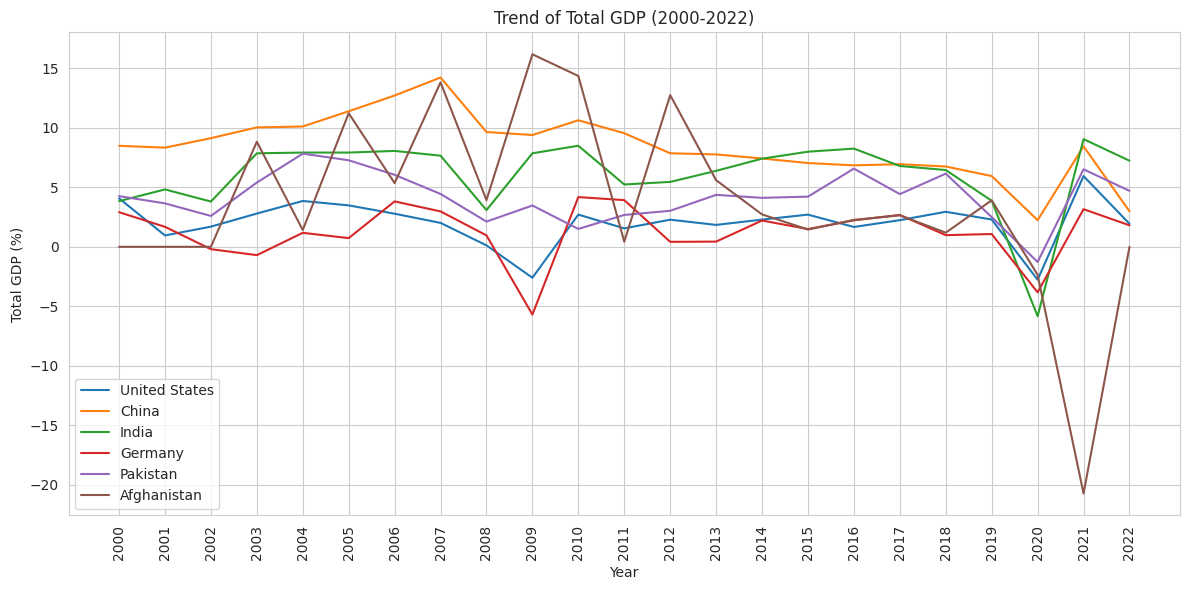

In [4]:
# Time Series plot
sns.set_style("whitegrid")
timeplot_countries = ['United States', 'China', 'India', 'Germany', 'Pakistan', 'Afghanistan']
time_series_data = gdp_data[gdp_data['Country Name'].isin(timeplot_countries)]
last_23_years = time_series_data.columns[-23:]

plt.figure(figsize=(12, 6))
for country in timeplot_countries:
    plt.plot(last_23_years, time_series_data[time_series_data['Country Name'] == country][last_23_years].iloc[0], label=country)

plt.title('Trend of Total GDP (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Total GDP (%)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

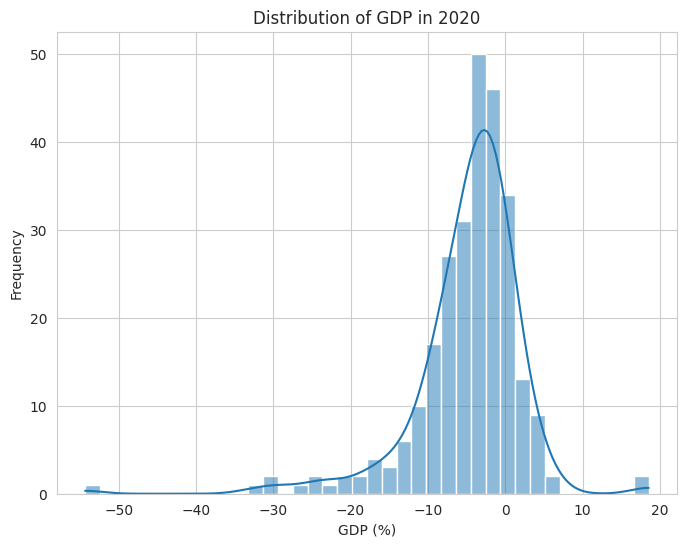

In [5]:
#Histogram
plt.figure(figsize=(8, 6))
sns.histplot(gdp_data['2020'].dropna(), kde=True)
plt.title('Distribution of GDP in 2020')
plt.xlabel('GDP (%)')
plt.ylabel('Frequency')
plt.show()

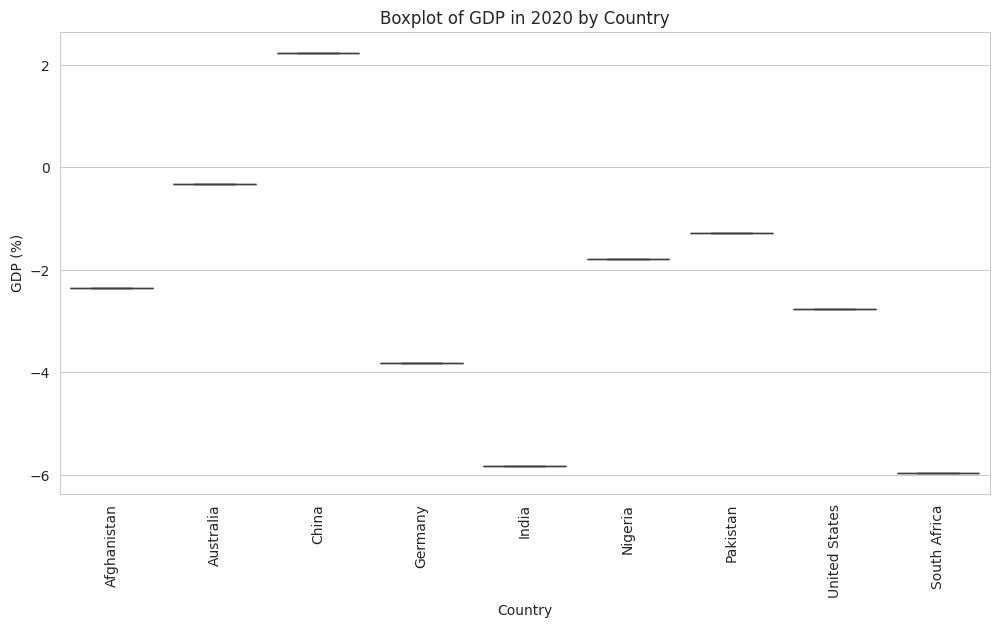

In [6]:
# Boxplot
boxplot_region = ['United States', 'China', 'India', 'Germany', 'Afghanistan', 'Australia', 'Nigeria', 'Russia', 'Pakistan', 'South Africa']
boxplot_data = gdp_data[gdp_data['Country Name'].isin(boxplot_region)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_data, x='Country Name', y='2020')
plt.title('Boxplot of GDP in 2020 by Country')
plt.xlabel('Country')
plt.ylabel('GDP (%)')
plt.xticks(rotation=90)
plt.show()


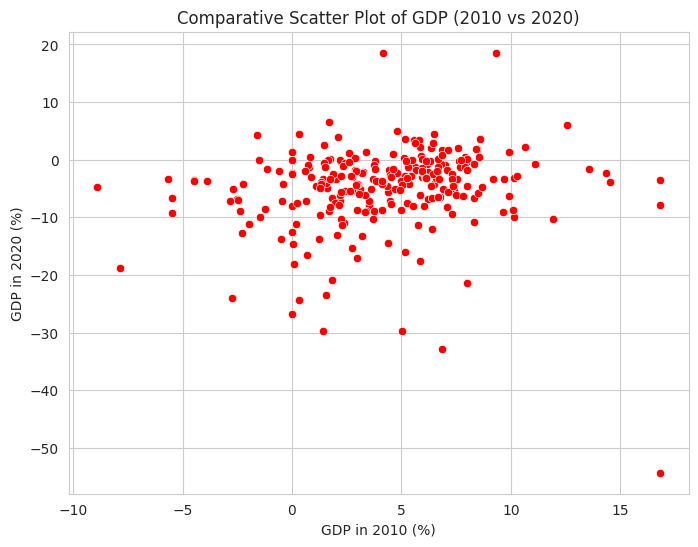

In [7]:
# Scatter Plot comparison
plt.figure(figsize=(8, 6))
sns.scatterplot(data=gdp_data, x='2010', y='2020', color ='red')
plt.title('Comparative Scatter Plot of GDP (2010 vs 2020)')
plt.xlabel('GDP in 2010 (%)')
plt.ylabel('GDP in 2020 (%)')
plt.show()

/home/indexworld/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


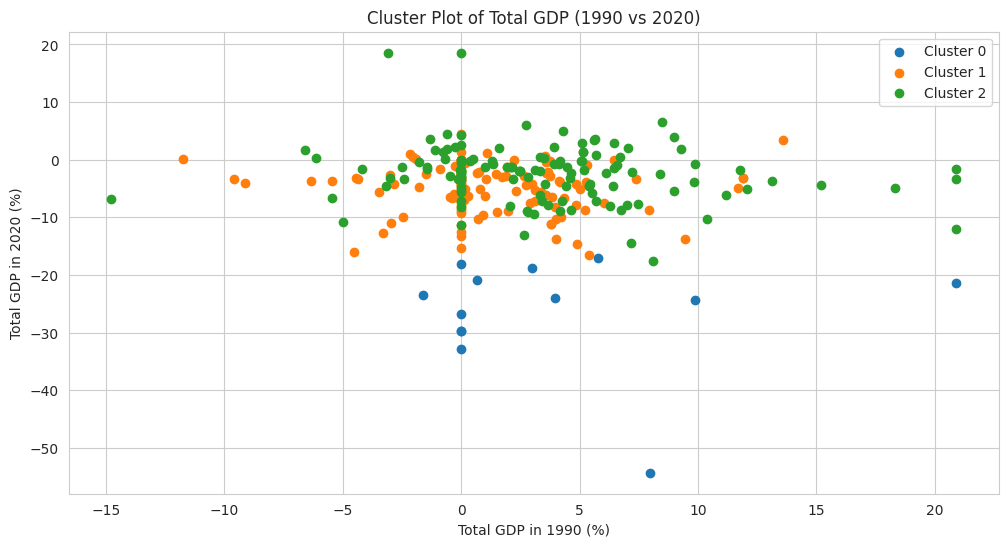

In [8]:
cluster_years = ['1990', '2000' ,'2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
cluster_data = gdp_data.set_index('Country Name')[cluster_years].dropna()
kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_data)
cluster_data['Cluster'] = kmeans.labels_

plt.figure(figsize=(12, 6))
for cluster in np.unique(kmeans.labels_):
    cluster_subset = cluster_data[cluster_data['Cluster'] == cluster]
    plt.scatter(cluster_subset['1990'], cluster_subset['2020'], label=f'Cluster {cluster}')

plt.title('Cluster Plot of Total GDP (1990 vs 2020)')
plt.xlabel('Total GDP in 1990 (%)')
plt.ylabel('Total GDP in 2020 (%)')
plt.legend()
plt.show()

In [9]:
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def calculate_fit_and_predict(data, model_func, years_to_predict):
    x_axis_data = np.array(range(len(data)))
    y_axis_data = data.values
    params, _ = curve_fit(model_func, x_axis_data, y_axis_data, maxfev=30000)
    future_x_axis = np.array(range(len(data) + years_to_predict))
    future_y_axis = model_func(future_x_axis, *params)

    return future_x_axis, future_y_axis, params

def error_ranges(params, cov, x):
    partials = np.array([x**i for i in range(len(params))])
    sigma_y = np.sqrt(np.sum((cov @ partials)**2, axis=0))
    return sigma_y

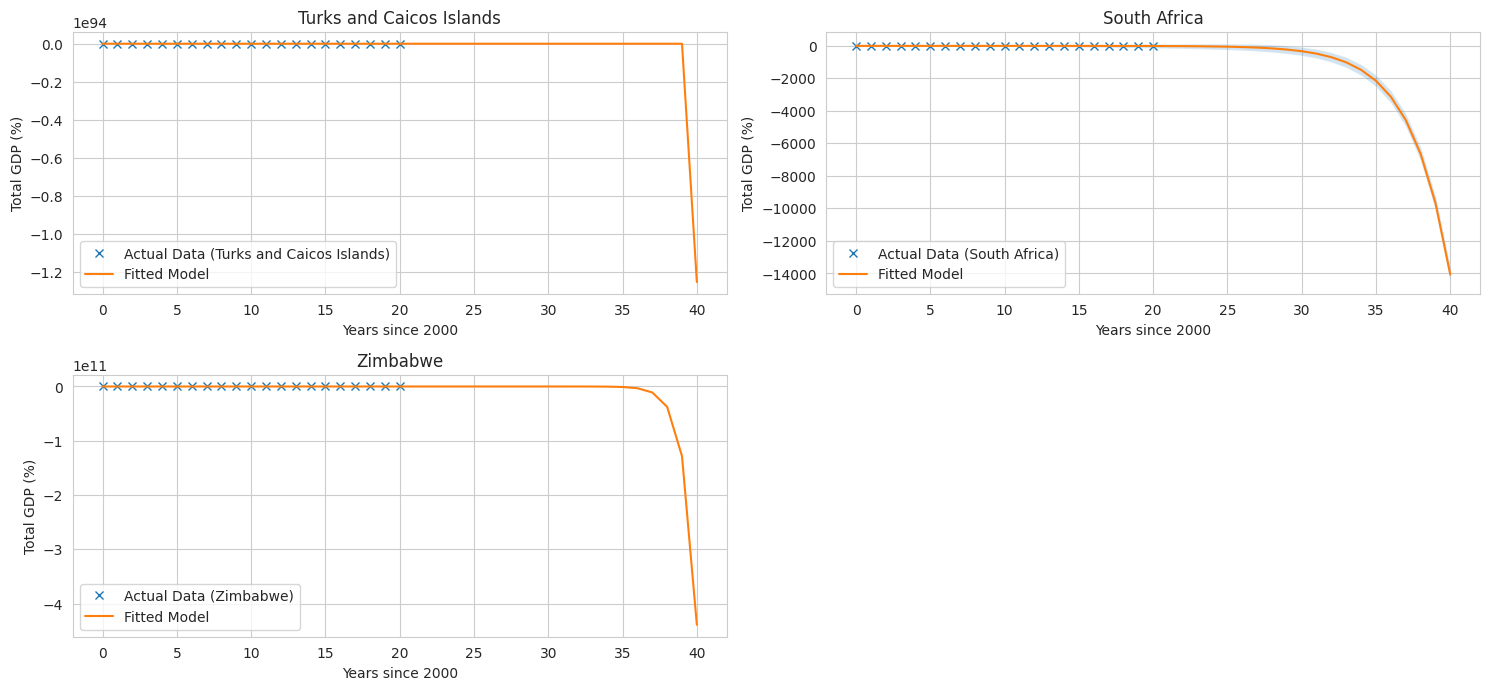

In [10]:
selected_countries = cluster_data.reset_index().groupby('Cluster')['Country Name'].last()
selected_countries_list = selected_countries.tolist()
fit_years = [str(year) for year in range(2000, 2021)]
fit_data = gdp_data[gdp_data['Country Name'].isin(selected_countries_list)]
fit_data = fit_data[['Country Name'] + fit_years].set_index('Country Name')
years_to_predict = 20
predictions = {}

for country in selected_countries_list:
    data = fit_data.loc[country]
    future_x_axis, future_y_axis, _ = calculate_fit_and_predict(data, exponential, years_to_predict)
    predictions[country] = (future_x_axis, future_y_axis)

predictions[selected_countries_list[0]]
plt.figure(figsize=(15, 10))
for i, country in enumerate(selected_countries_list):
    data = fit_data.loc[country]
    x_axis_data = np.array(range(len(data)))
    y_axis_data = data.values
    params, cov = curve_fit(exponential, x_axis_data, y_axis_data, maxfev=30000)
    future_x_axis = np.array(range(len(data) + years_to_predict))
    future_y_axis = exponential(future_x_axis, *params)
    sigma_y = error_ranges(params, cov, future_x_axis)

    plt.subplot(3, 2, i+1)
    plt.plot(future_x_axis[:len(data)], y_axis_data, 'x', label=f'Actual Data ({country})')
    plt.plot(future_x_axis, future_y_axis, '-', label='Fitted Model')
    plt.fill_between(future_x_axis, future_y_axis - sigma_y, future_y_axis + sigma_y, alpha=0.2)
    plt.title(country)
    plt.xlabel('Years since 2000')
    plt.ylabel('Total GDP (%)')
    plt.legend()

plt.tight_layout()
plt.show()